In [1]:
%load_ext autoreload
%autoreload 2

import pyVHR as vhr
import numpy as np
from pyVHR.analysis.pipeline import Pipeline
from pyVHR.plot.visualize import *
import os
import plotly.express as px
from pyVHR.utils.errors import getErrors, printErrors, displayErrors

import constants
import pandas as pd

vhr.plot.VisualizeParams.renderer = 'vscode' 

In [2]:
from numpy.lib.arraysetops import isin
import pandas as pd
import numpy as np
from importlib import import_module, util
from pyVHR.utils.errors import getErrors
from pyVHR.extraction.sig_processing import *
from pyVHR.extraction.sig_extraction_methods import *
from pyVHR.extraction.skin_extraction_methods import *
from pyVHR.BVP.BVP import *
from pyVHR.BPM.BPM import *
from pyVHR.BVP.methods import *
from pyVHR.BVP.filters import *
from inspect import getmembers, isfunction
from pyVHR.deepRPPG.mtts_can import *
from pyVHR.deepRPPG.hr_cnn import *
from pyVHR.extraction.utils import *
from dtw import *
import scipy

from tqdm import tqdm

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# PURE

1min, FPS 30 Hz, 640 x 480 pixels

Pulse rate 60 Hz

- Steady - Talking - Slow Translation - Fast Translatoin - Small Rotation - Medium Rotation

In [2]:
import json 

filename = 'D:/datasets_rppg/PURE/01-01/01-01.json'
bvp = []

with open(filename) as json_file:
    json_data = json.load(json_file)
    for p in json_data['/FullPackage']:
        bvp.append(p['Value']['waveform'])
bvp = np.array(bvp)

In [3]:
# load npy file
data = np.load('D:/datasets_rppg/PURE/PURE_npy_all/RGB_01-01.npy', allow_pickle=True)
size = int(np.sqrt(data.shape[-1]))

print(f"NPY data of shape {data.shape}: 1 min video of {data.shape[0]} frames is {data.shape[0]/60} fps") 
print(f"Total number of pixels is {data.shape[-1]}, height and width is {np.sqrt(data.shape[-1])}")
print(f"Then {size} squared is {size*size} pixels")

NPY data of shape (455, 3, 2026): 1 min video of 455 frames is 7.583333333333333 fps
Total number of pixels is 2026, height and width is 45.0111097397076
Then 45 squared is 2025 pixels


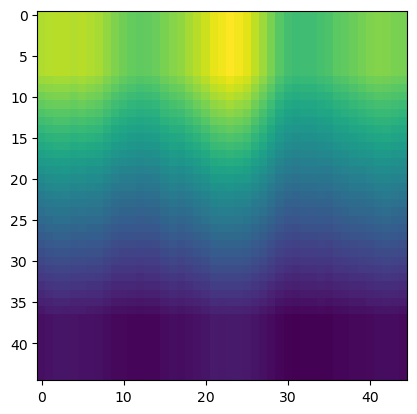

In [4]:
import cv2

img = data[390]
img = cv2.resize(img, (size, size))
plt.imshow(img)

In [5]:
# -- LOAD A DATASET

dataset_name = 'PURE'    
video_DIR, BVP_DIR = 'D:/datasets_rppg/PURE/', 'D:/datasets_rppg/PURE/'

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

D:/datasets_rppg/PURE/


TypeError: 'NoneType' object is not subscriptable

# UBFC-PHYS

- rest task T1
- speech task T2
- arithmetic task T3

In [3]:
# -- LOAD A DATASET

dataset_name = 'ubfc_phys'    
videoFPS, sigFPS = constants.get_fps(dataset_name)
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# -- PARAMETER SETTING

wsize = 10        # seconds of video processed (with overlapping) for each estimate 
video_idx = 0    # index of the video to be processed
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)

Video processed name:  D:/datasets_rppg/UBFC-Phys\s1\vid_s1_T1.avi
Video frame rate:      35.138


In [4]:
subject = videoFileName.split('\\')[1]
px.line(x=timesGT, y=bpmGT, title=f'BPM {subject}', labels={'x':'Time (s)', 'y':'BPM'})

In [5]:
SAMPLING = '2000'
dataset_name = 'UBFC_PHYS'
df = pd.read_hdf(f'../results/landmarks/{dataset_name}/{SAMPLING}/{dataset_name}_18_{SAMPLING}.h5')
#  df = pd.read_hdf(f'../results/no_overlap/{dataset_name}/{SAMPLING}_win10-0/{dataset_name}_18.h5')
# df = df[df['landmarks'].isin([('glabella',)])].query('method == "cupy_CHROM"')
df['MAE'] = df['MAE'].apply(lambda x: x[0])
df['tmp'] = df['videoFilename'].apply(lambda x: int(x[1:]))
df = df.query('method == "cupy_CHROM"').sort_values(['tmp','MAE']).drop_duplicates(['videoFilename']).reset_index(drop=True)
df.head(1)

,method,dataset,videoFilename,videoIdx,RMSE,MAE,PCC,CCC,SNR,MAX,...,bpmES,bpmES_mad,timeGT,timeES,landmarks,timePCC,timeDTW,ROI,SAMPLING,tmp
0,cupy_CHROM,ubfc_phys,s1,0,[18.156910079442586],15.300284,[-0.28983040348992656],[-0.2842007867237181],[-3.9254786822718777],[36.840339660644524],...,"[90.59015655517578, 68.97205352783203, 67.4279...","[1.0294336080551147, 0.0, 0.5147168040275574, ...","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....","(left_nasolabial_fold, right_nasolabial_fold)","[0.05736600257725921, 0.11719434512633799, 0.0...",19.44131,mustache,2000,1


In [6]:
x = df.query('videoFilename == "s52"').iloc[0]
video_idx = x.videoIdx
subject = x.videoFilename
fig = go.Figure()
fig.add_trace(go.Scatter(x=x.timeGT, y=x.bpmGT, mode='lines', name='GT'))
fig.add_trace(go.Scatter(x=x.timeES, y=x.bpmES, mode='lines', name='ES'))
fig.update_layout(title=f'BPM {subject}',
                   xaxis_title='Time (s)',
                   yaxis_title='BPM')
fig.show()

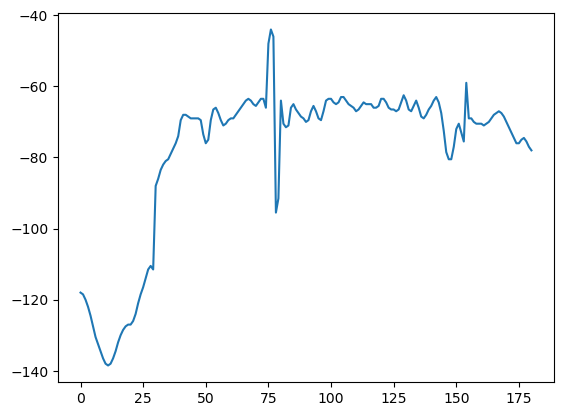

In [7]:
bpm = - x.bpmGT
peaks, props = scipy.signal.find_peaks(bpm, distance=0.35*sigFPS, height=0.0)
# plot peaks
fig = go.Figure()
fig.add_trace(go.Scatter(x=x.timeGT, y=bpm, mode='lines', name='BPM'))
fig.add_trace(go.Scatter(x=x.timeGT[peaks], y=bpm[peaks], mode='markers', name='peaks'))
fig.update_layout(title=f'BPM {subject}',
                   xaxis_title='Time (s)',
                   yaxis_title='BPM')
plt.plot(bpm)
plt.plot(peaks, bpm[peaks], "x")


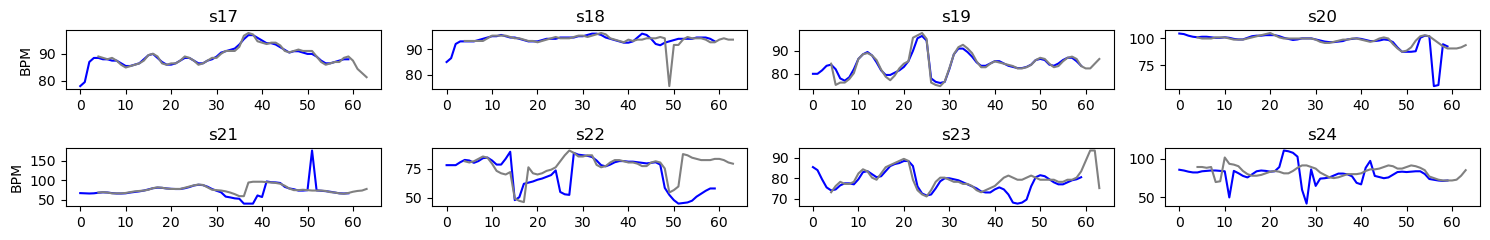

In [8]:
import matplotlib.pyplot as plt

idx = 16
subjects = df.videoFilename.iloc[idx:idx+8].values
fig, axs = plt.subplots(2, 4, figsize=(15, 2.5))

# Add each trace to the corresponding subplot
for i, ax in enumerate(axs.flat):
    x = df.iloc[idx+i]  # Assuming df contains the necessary data
    subject = x.videoFilename
    
    ax.plot(x.timeGT[:60], x.bpmGT[:60], label='GT', color='blue')
    ax.plot(x.timeES[:60], x.bpmES[:60], label='ES', color='gray')
    ax.set_title(subject)
    # ax.set_xlabel('Time (s)' if i//2 == 3 else '')
    ax.set_ylabel('BPM' if i%4 == 0 else '')

# Show the combined figure
plt.tight_layout()
plt.show()

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

idx = 0
subjects = df.videoFilename.iloc[idx:idx+8].values
fig = make_subplots(rows=4, cols=2, subplot_titles=subjects)

# Add each trace to the corresponding subplot
for i in range(8):
    x = df.iloc[idx+i]  # Assuming df contains the necessary data
    subject = x.videoFilename
    
    fig.add_trace(go.Scatter(x=x.timeGT[:60], y=x.bpmGT[:60], mode='lines', name='GT', line=dict(color='blue')), row=(i//2)+1, col=(i%2)+1)
    fig.add_trace(go.Scatter(x=x.timeES[:60], y=x.bpmES[:60], mode='lines', name='ES', line=dict(color='orange')), row=(i//2)+1, col=(i%2)+1)
    # peaks, props = scipy.signal.find_peaks(-x.bpmGT, rel_height=0)
    # fig.add_trace(go.Scatter(x=x.timeGT[peaks], y=x.bpmGT[peaks], mode='markers', name='peaks', marker=dict(color='blue')), row=(i//2)+1, col=(i%2)+1)

# Update layout
fig.update_layout(showlegend=False, height=600, width=1000)

# Update axes titles
fig.update_xaxes(title_text="Time (s)", row=4, col=1)
fig.update_yaxes(title_text="BPM", row=2, col=1)

# Show the combined figure
fig.show()


## Index Videos

<AxesSubplot: title={'center': 'MAE'}, xlabel='videoFilename'>

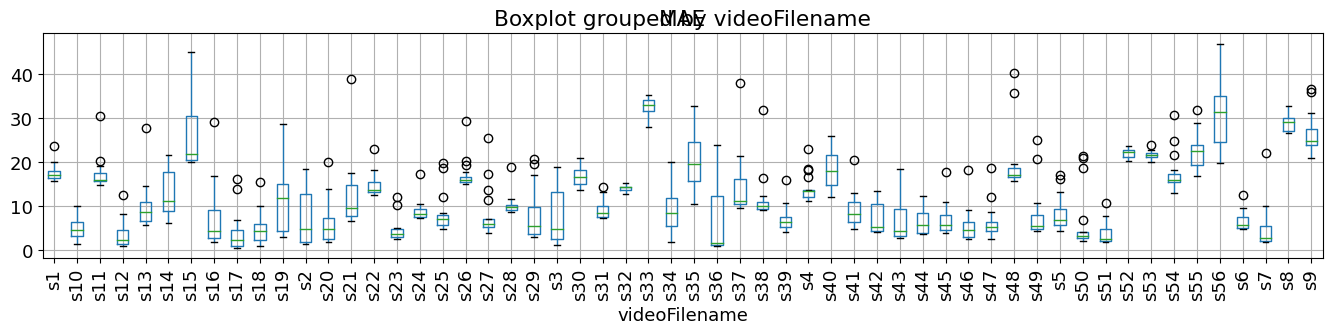

In [149]:
import analyze
df = pd.read_hdf(f'../results/landmarks/UBFC_PHYS/2000/UBFC_PHYS_18_2000.h5')
df = analyze.format_data(df)
df.boxplot(column='MAE', by='videoFilename', figsize=(16,3), rot=90)
# df.boxplot(column='timeDTW', by='videoFilename', figsize=(16,3), rot=90)

In [143]:
df[df['min(MAE) > 5'] == True].videoFilename.unique()

array(['s1', 's6', 's8', 's9', 's11', 's14', 's15', 's22', 's24', 's26',
       's28', 's30', 's32', 's33', 's35', 's37', 's40', 's48', 's52',
       's53', 's55', 's56'], dtype=object)

Sampling - window - overlap:  ['2000_win10-0']
(1008, 18) ROI:  ['forehead' 'nose' 'mustache' 'temple' 'cheeks' 'jaw'] 6
Landmarks:  18


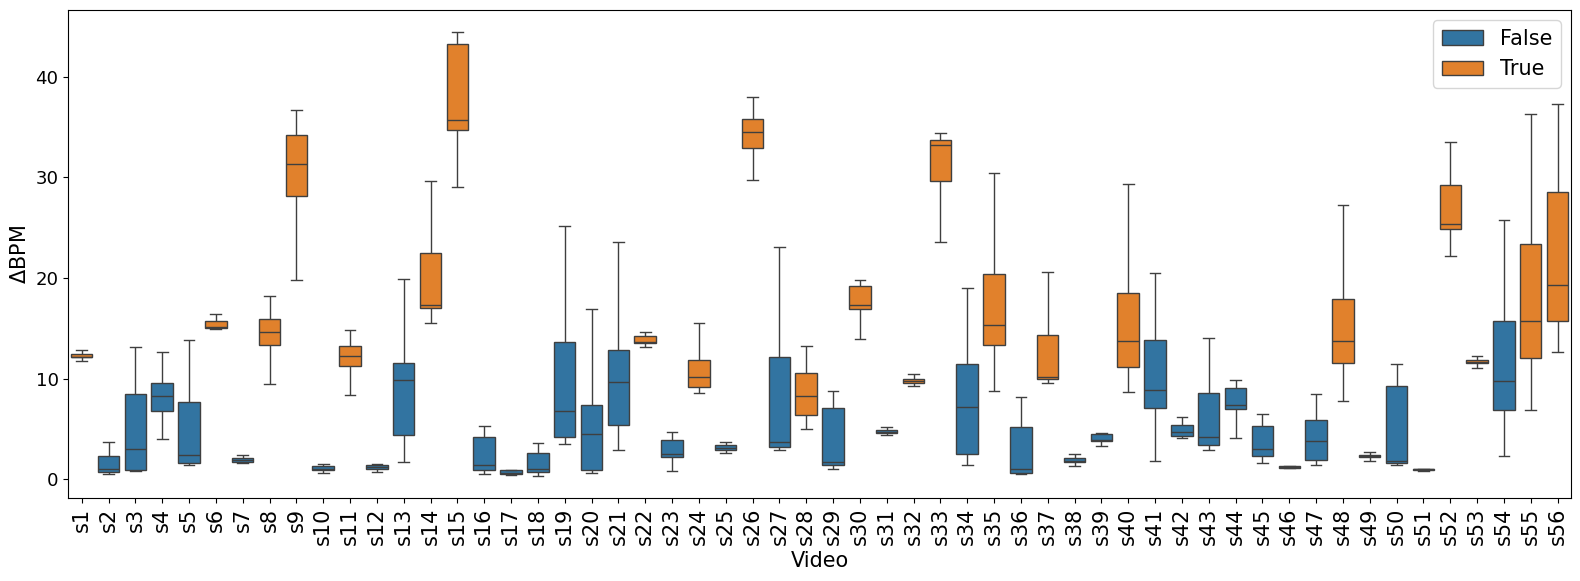

In [155]:
import seaborn as sns
dataset_name = 'UBFC_PHYS'
df = pd.read_hdf(f'../results/no_overlap/{dataset_name}/2000_win10-0/{dataset_name}_18.h5')
print("Sampling - window - overlap: ", df.config.unique())
df = df.query("method == 'cupy_CHROM'") # TODO
print(df.shape, "ROI: ", df.ROI.unique(), df.ROI.unique().size)
print("Landmarks: ", df.landmarks.unique().size)
df.head(1)

df['tmp']  = df['videoFilename'].apply(lambda x: int(x[1:]))
df = df.sort_values('tmp').reset_index(drop=True)
df['MAE'] = df['MAE'].apply(lambda x: x[0])
df['video_MAE'] = df.groupby('videoFilename')['MAE'].transform('min')  
df['min(MAE) > 5'] = df['video_MAE'].apply(lambda x: x > 5)
df = df.sort_values('tmp').reset_index(drop=True)
fig = plt.figure(figsize=(16,6))
sns.boxplot(data=df, x='videoFilename', y='MAE', hue='min(MAE) > 5', showfliers=False)
plt.xticks(rotation=90, fontsize=15)
plt.xlabel('Video', fontsize=15)
plt.ylabel(r'$\Delta$BPM', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()

In [120]:
df[df['min(MAE) > 5'] == True].videoFilename.unique()   

array(['s1', 's6', 's8', 's9', 's11', 's14', 's15', 's22', 's24', 's26',
       's28', 's30', 's32', 's33', 's35', 's37', 's40', 's48', 's52',
       's53', 's55', 's56'], dtype=object)

Bad subjects by visual inspection of video and PPG signal:  22 ['s1', 's11', 's13', 's15', 's17', 's22', 's24', 's25', 's26', 's30', 's33', 's34', 's4', 's48', 's49', 's52', 's53', 's54', 's55', 's56', 's8', 's9']


<AxesSubplot: title={'center': 'MAE'}, xlabel='videoFilename'>

<Figure size 640x480 with 0 Axes>

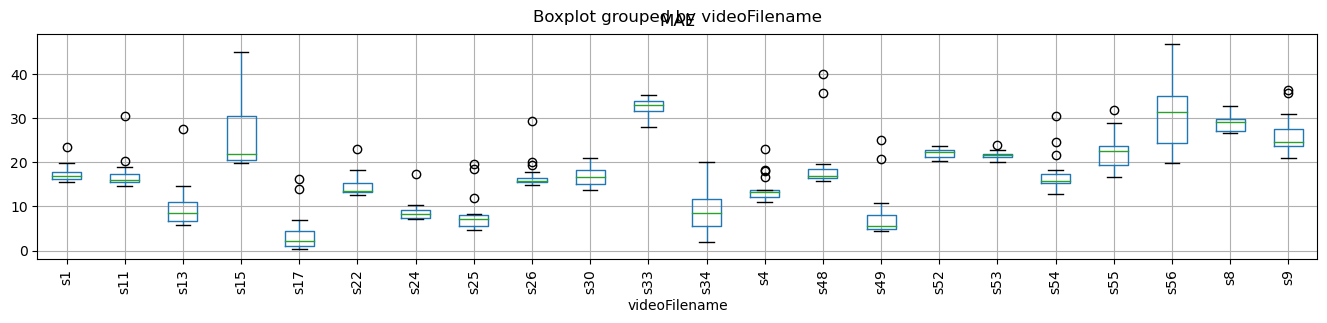

<Figure size 640x480 with 0 Axes>

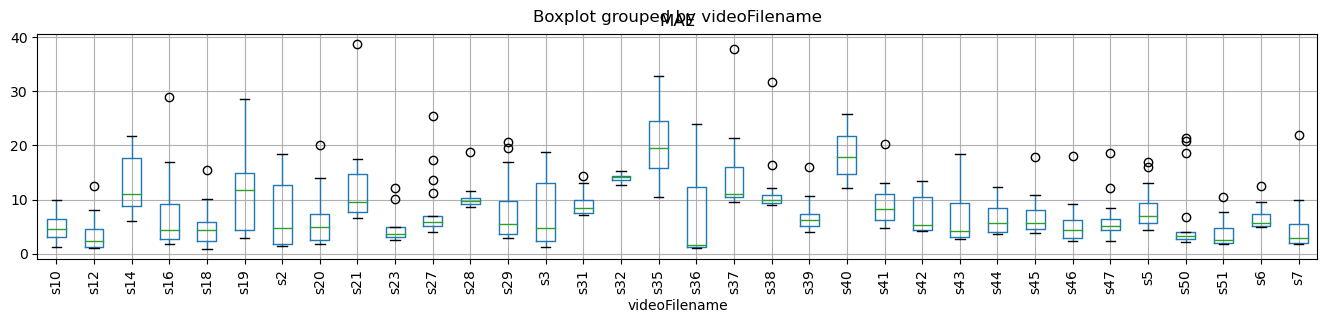

In [11]:
bad_video = ['s1','s13','s17','s24','s26','s30','s34','s55','s56', 's9'] # by visual inspection of video
bad_ppg = ['s1', 's11', 's15', 's22', 's25', 's26', 's33', 's4', 's48', 's49', 's52', 's53', 's54', 's55', 's56', 's8' ] # by visual inspection of ppg signals
bad_subjects = list(set(bad_video + bad_ppg))
bad_subjects.sort()
print('Bad subjects by visual inspection of video and PPG signal: ', len(bad_subjects), bad_subjects)

plt.figure()
df[df['videoFilename'].isin(bad_subjects)].boxplot(column='MAE', by='videoFilename', figsize=(16,3), rot=90)
plt.figure()
df[~df['videoFilename'].isin(bad_subjects)].boxplot(column='MAE', by='videoFilename', figsize=(16,3), rot=90)

Unusable subjects:  19 ['s48', 's11', 's30', 's40', 's8', 's33', 's26', 's54', 's56', 's32', 's9', 's52', 's53', 's22', 's15', 's55', 's1', 's35', 's4']


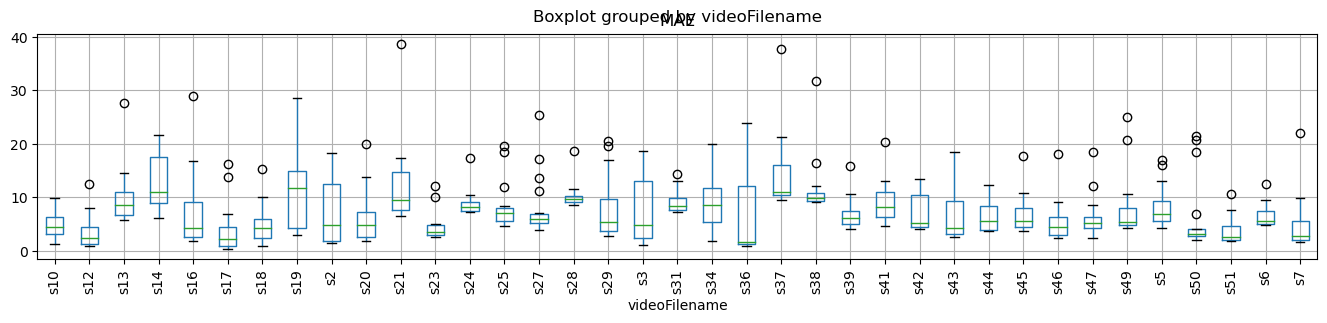

In [12]:
df.groupby('videoFilename').filter(lambda x: x['MAE'].min() < 10).boxplot(column='MAE', by='videoFilename', figsize=(16,3), rot=90)
all_subjects = df.videoFilename.unique()
still_subjects = df.groupby('videoFilename').filter(lambda x: x['MAE'].min() < 10).videoFilename.unique()
bad_subjects = list(set(all_subjects) - set(still_subjects))
print("Unusable subjects: ", len(bad_subjects), bad_subjects)
# df1.query('videoFilename == "s14"')[['landmarks', 'videoFilename', 'videoIdx'] + metrics].sort_values(by='landmarks')

In [ ]:
for i,dir in enumerate(os.listdir(f'D:/datasets_rppg/UBFC-Phys/')):
    path = f'D:/datasets_rppg/UBFC-Phys/{dir}/'
    videos = [video for video in os.listdir(path) if video.endswith('.avi')]
    if sum(['T3' in video for video in videos]) == 0:
        print(f"Subject {dir} has no T3")
    if sum(['T2' in video for video in videos]) == 0:
        print(f"Subject {dir} has no T2")
    if sum(['T1' in video for video in videos]) == 0:
        print(f"Subject {dir} has no T1")

In [148]:
MALE = ['s1','s2','s19','s25','s29','s35','s38','s47','s48','s49']
# bad_video = ['s1','s13','s17','s24','s26','s30','s34','s55','s56', 's9'] # by visual inspection of video
# bad_ppg = ['s1', 's11', 's15', 's22', 's25', 's26', 's33', 's4', 's48', 's49', 's52', 's53', 's54', 's55', 's56', 's8' ] # by visual inspection of ppg signals
ROTATION = ['s1', 's11', 's13', 's15', 's17', 's22', 's24', 's25', 's26', 's30', 's33', 's34', 's4', 's48', 's49', 's52', 's53', 's54', 's55', 's56', 's8', 's9']
# ROTATION = ['s15', 's11', 's54', 's40', 's55', 's32', 's52', 's9', 's8', 's56', 's26', 's1', 's35', 's30', 's53', 's33', 's22', 's4', 's48'] # by 18 landmarks, MAE.min() > 10
GLASSES = ['s4','s6','s7','s9','s15','s16','s17','s19','s30','s34','s35','s42','s45']
MUSTACHE = ['s1','s2', 's19','s35','s38', 's47', 's48', 's49']
BEARD = ['s2','s19','s38','s48','s49']
DARK = ['s7','s37','s48','s50','s56']
BANG = ['s8', 's27','s30','s47','s51','s52']
# BANG = ['s8', 's27','s29','s30','s47','s51','s52'] # original

still = []
males = []
females = []
glasses = []
beards = []
darks = []
bangs = []
rotations = []
# print the list of video names with the progressive index (idx)
for v, video in enumerate(allvideo):
    if 'T1' in video:
        person = video.split('\\')[1]
        if person in MALE:
            males.append(v)
        else:
            females.append(v)

        if person in GLASSES:
            glasses.append(v)
            
        if person in BEARD:
            beards.append(v)
        
        if person in DARK:
            darks.append(v)

        if person in BANG:
            bangs.append(v)
        
        if person in ROTATION:
            rotations.append(v)
        else: 
            still.append(v)

print(still)
print(males)
print(females)
print(glasses)
print(rotations)
print(beards)
print(darks)
print(bangs)

[3, 9, 15, 21, 27, 30, 33, 36, 39, 45, 57, 60, 63, 66, 72, 75, 84, 87, 90, 93, 96, 102, 105, 108, 111, 114, 117, 120, 123, 132, 135, 138, 156, 159]
[0, 30, 33, 51, 63, 84, 93, 123, 126, 129]
[3, 6, 9, 12, 15, 18, 21, 24, 27, 36, 39, 42, 45, 48, 54, 57, 60, 66, 69, 72, 75, 78, 81, 87, 90, 96, 99, 102, 105, 108, 111, 114, 117, 120, 132, 135, 138, 141, 144, 147, 150, 153, 156, 159, 162, 165]
[18, 21, 24, 30, 69, 81, 84, 99, 108, 117, 156, 159, 165]
[0, 6, 12, 18, 24, 42, 48, 51, 54, 69, 78, 81, 99, 126, 129, 141, 144, 147, 150, 153, 162, 165]
[30, 33, 93, 126, 129]
[90, 126, 135, 153, 159]
[57, 69, 123, 138, 141, 162]


# LGI-PPGI

reference

In [153]:
# -- LOAD A DATASET

dataset_name = 'lgi_ppgi'    
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

# -- PARAMETER SETTING

wsize = 8        # seconds of video processed (with overlapping) for each estimate 
video_idx = 1    # index of the video to be processed
fname = dataset.getSigFilename(video_idx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(wsize)
videoFileName = dataset.getVideoFilename(video_idx)
print('Video processed name: ', videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<AxesSubplot: title={'center': 'timeDTW'}, xlabel='videoFilename'>

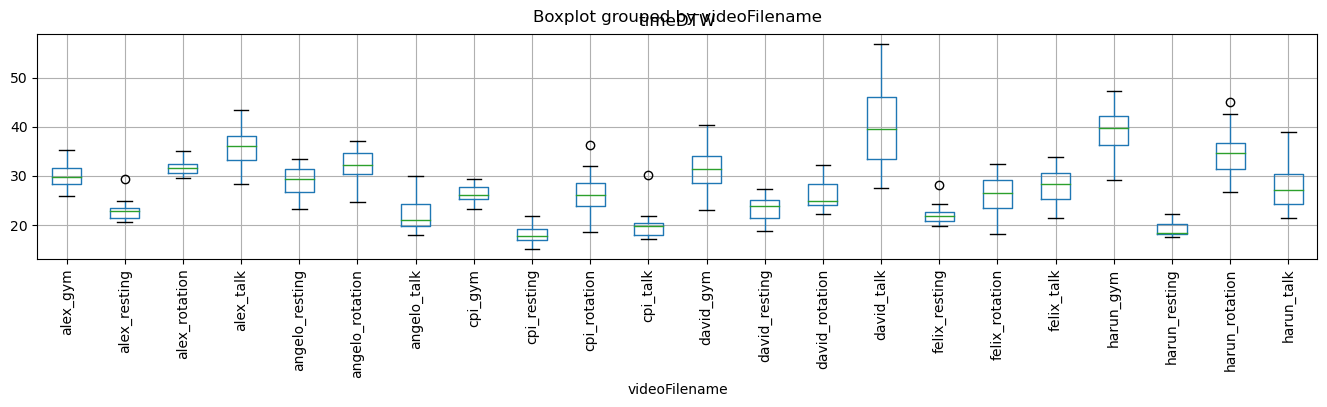

In [15]:
import analyze
df = pd.read_hdf(f'../results/landmarks/LGI_PPGI/2000/LGI_PPGI_18_2000.h5')
df = analyze.format_data(df)
df.boxplot(column='timeDTW', by='videoFilename', figsize=(16,3), rot=90)

# MR NIRP

- Pulse oximeter measurements (same as LGI-PPGI)
- The raw 10-bit images were recorded with 640 × 640 resolution at 30 fps. -> avi is 25 though
- We used a CMS 50D+ finger pulse oximeter to obtain a  round-truth PPG waveform recorded at 60 fps

## Performance by video

<AxesSubplot: title={'center': 'MAE'}, xlabel='videoFilename'>

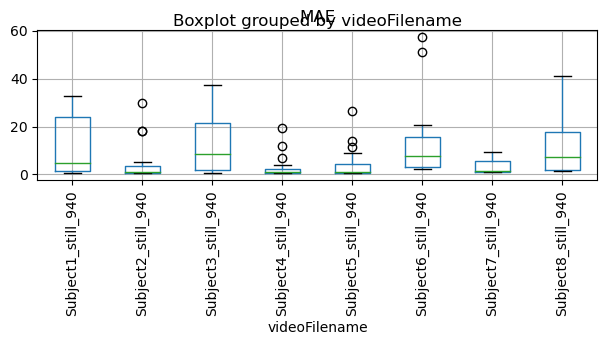

In [40]:
import analyze
df = pd.read_hdf(f'../results/landmarks/MR_NIRP/2000/MR_NIRP_18_2000.h5')
df = analyze.format_data(df)
df[df['videoFilename'].apply(lambda x: 'still' in x)].boxplot(column='MAE', by='videoFilename', figsize=(7,2), rot=90)

<AxesSubplot: title={'center': 'timeDTW'}, xlabel='videoFilename'>

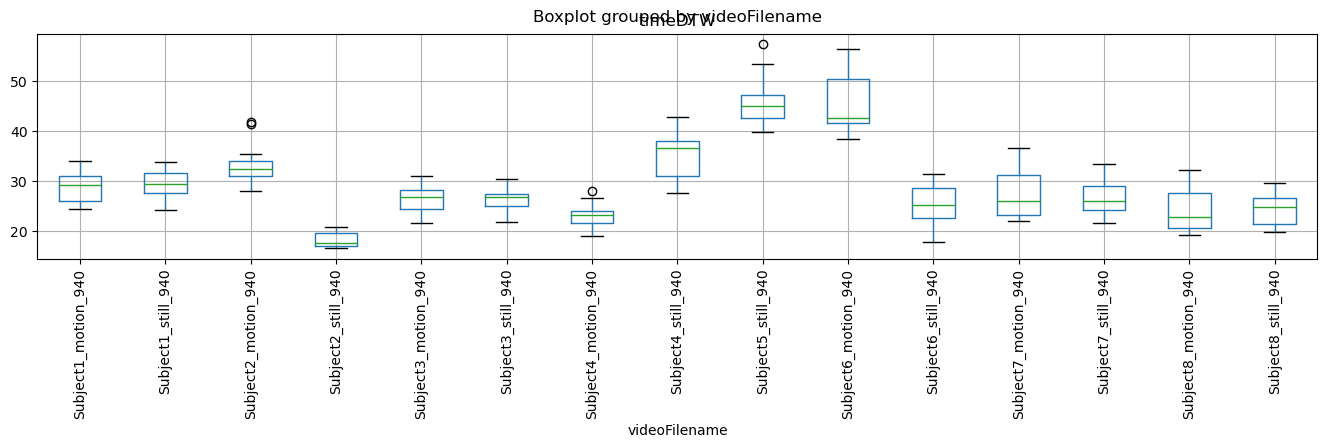

In [139]:
import analyze
df = pd.read_hdf(f'../results/landmarks/MR_NIRP/2000/MR_NIRP_18_2000.h5')
df = analyze.format_data(df)
df.boxplot(column='timeDTW', by='videoFilename', figsize=(16,3), rot=90)

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

idx = 7
SAMPLING = '2000'
dataset_name = 'MR_NIRP'
df = pd.read_hdf(f'../results/landmarks/{dataset_name}/{SAMPLING}/{dataset_name}_18_{SAMPLING}.h5')
# df = df[df['landmarks'].isin([('upper_nasal_dorsum',)])].query('method == "cupy_CHROM"')
df = df[df['landmarks'].isin([('glabella',)])].query('method == "cupy_CHROM"')

subjects = df.videoFilename.iloc[idx:idx+8].values
fig = make_subplots(rows=4, cols=2, subplot_titles=subjects)

# Add each trace to the corresponding subplot
for i in range(8):
    x = df.iloc[idx+i]  # Assuming df contains the necessary data
    subject = x.videoFilename
    
    fig.add_trace(go.Scatter(x=x.timeGT, y=x.bpmGT, mode='lines', name='GT', line=dict(color='blue')), row=(i//2)+1, col=(i%2)+1)
    fig.add_trace(go.Scatter(x=x.timeES, y=x.bpmES, mode='lines', name='ES', line=dict(color='orange')), row=(i//2)+1, col=(i%2)+1)
    peaks, props = scipy.signal.find_peaks(-x.bpmGT, rel_height=0)
    fig.add_trace(go.Scatter(x=x.timeGT[peaks], y=x.bpmGT[peaks], mode='markers', name='peaks', marker=dict(color='blue')), row=(i//2)+1, col=(i%2)+1)

# Update layout
fig.update_layout(showlegend=False, height=600, width=1200)

# Update axes titles
fig.update_xaxes(title_text="Time (s)", row=4, col=1)
fig.update_yaxes(title_text="BPM", row=2, col=1)

# Show the combined figure
fig.show()


## Dataset

In [5]:
import scipy.io
path = 'D:/datasets_rppg/MR-NIRP_indoor/Subject1_motion_940/Subject1_motion_940/PulseOX/'
data = scipy.io.loadmat(path+'pulseOx.mat')
print(data.keys())
print(data['pulseOxRecord'].shape, data['pulseOxTime'].shape)
print(f"{data['pulseOxRecord'].shape[-1]} frames with 60 fps so {data['pulseOxRecord'].shape[-1]/60} seconds")
pd.DataFrame([data])

dict_keys(['__header__', '__version__', '__globals__', 'pulseOxRecord', 'pulseOxTime', 'numPulseSample'])
(1, 3910) (1, 3910)
3910 frames with 60 fps so 65.16666666666667 seconds


,__header__,__version__,__globals__,pulseOxRecord,pulseOxTime,numPulseSample
0,"b'MATLAB 5.0 MAT-file Platform: posix, Created...",1.0,[],"[[[[43]], [[43]], [[44]], [[44]], [[43]], [[42...","[[1519076918.648566, 1519076918.665297, 151907...",[[3910]]


In [6]:
# load npy file: is this maybe the video NPY?
data = np.load(path+'pulseOx.npy', allow_pickle=True)
size = int(np.sqrt(data.shape[-1]))
print("Size: ", data.shape)
print(f"There are 1965 pictures in the picture folder with 30 fps so {1965 / 30}s of video makes sense")

print(f"Maybe this is the NPY of the video with {data.shape[-1]} frames")
print(f"If video fps is 30, then the video is {data.shape[-1]/30} seconds long")
print(f"If video fps is 25, then the video is {data.shape[-1]/25} seconds long")
print(f"But this does not make sense, 1800 should be the image pixels and 467 the frames")

Size:  (1, 467, 3, 1800)
There are 1965 pictures in the picture folder with 30 fps so 65.5s of video makes sense
Maybe this is the NPY of the video with 1800 frames
If video fps is 30, then the video is 60.0 seconds long
If video fps is 25, then the video is 72.0 seconds long
But this does not make sense, 1800 should be the image pixels and 467 the frames


In [8]:
# -- LOAD A DATASET

dataset_name = 'mr_nirp'   
wsize = 8        # seconds of video processed (with overlapping) for each estimate 
patch_size = constants.get_patch_size(dataset_name)
print(f"Patch size for {dataset_name} is {patch_size} ")
videoFPS, sigFPS = constants.get_fps(dataset_name)
print(f"Video fps for {dataset_name} is {videoFPS}, Signal fps is {sigFPS} ")
video_DIR, BVP_DIR = constants.get_dataset_paths(dataset_name)

dataset = vhr.datasets.datasetFactory(dataset_name, videodataDIR=video_DIR, BVPdataDIR=BVP_DIR)
allvideo = dataset.videoFilenames

videos = constants.get_video_settings(dataset_name)
print(videos)

# print the list of video names with the progressive index (idx)
for v in range(len(allvideo)):
  print(v, allvideo[v])

Patch size for mr_nirp is 60 
Video fps for mr_nirp is 30, Signal fps is 60 
{'MOTION': [0, 2, 4, 6, 9, 11, 13], 'STILL': [1, 3, 5, 7, 8, 10, 12], 'MALE': [0, 1, 4, 5, 6, 7, 8, 9, 10, 13, 14], 'FEMALE': [2, 3, 11, 12], 'BEARD': [0, 1, 4, 5, 8, 9, 10, 13, 13], 'DARK': [0, 1, 2, 3, 4, 5, 13, 14]}
0 D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
1 D:/datasets_rppg/MR-NIRP_indoor\Subject1_still_940-015\Subject1_still_940\RGB_corrected\Subject1_still_940.avi
2 D:/datasets_rppg/MR-NIRP_indoor\Subject2_motion_940\Subject2_motion_940\RGB_corrected\Subject2_motion_940.avi
3 D:/datasets_rppg/MR-NIRP_indoor\Subject2_still_940-002\Subject2_still_940\RGB_corrected\Subject2_still_940.avi
4 D:/datasets_rppg/MR-NIRP_indoor\Subject3_motion_940\Subject3_motion_940\RGB_corrected\Subject3_motion_940.avi
5 D:/datasets_rppg/MR-NIRP_indoor\Subject3_still_940-012\Subject3_still_940\RGB_corrected\Subject3_still_940.avi
6 D:/datasets_rppg/MR-NIRP_in

videoFileName :  D:/datasets_rppg/MR-NIRP_indoor\Subject1_motion_940\Subject1_motion_940\RGB_corrected\Subject1_motion_940.avi
Video frame rate:      30.0
Length of the video: 1:05 min, timesGT is 66 s
Signal frame rate is 60 fps for MR-NIRP and signal is  65.16666666666667 seconds worth


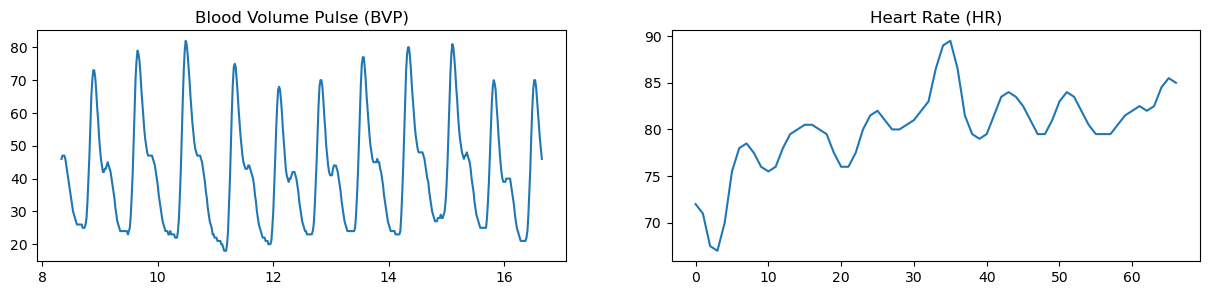

In [5]:
# -- PARAMETER SETTING

videoIdx = 0
fname = dataset.getSigFilename(videoIdx)
sigGT = dataset.readSigfile(fname)
bpmGT, timesGT = sigGT.getBPM(wsize) # STFT 42-240 BPM

videoFileName = dataset.getVideoFilename(videoIdx)
print("videoFileName : ", videoFileName)
fps = vhr.extraction.get_fps(videoFileName)
print('Video frame rate:     ',fps)
print(f"Length of the video: 1:05 min, timesGT is {len(timesGT)-1} s")
print("Signal frame rate is 60 fps for MR-NIRP and signal is ", sigGT.data.shape[1] / sigFPS, "seconds worth")

fig, ax = plt.subplots(1,2,figsize=(15,3))
ax[0].plot(np.arange(0, len(timesGT), 1/sigFPS)[500:1000], sigGT.data.T[500:1000])
ax[0].set_title('Blood Volume Pulse (BVP)')
ax[1].plot(timesGT, bpmGT)
ax[1].set_title('Heart Rate (HR)')
plt.show()

# Assess PPG

D:/datasets_rppg/UBFC-Phys\s26\bvp_s26_T1.csv


Text(0.5, 1.0, 's26: PPG pulses')

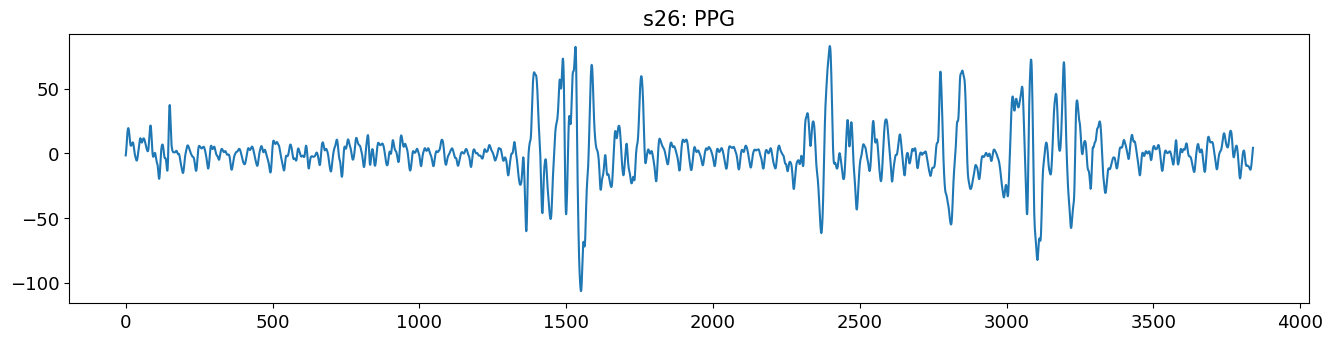

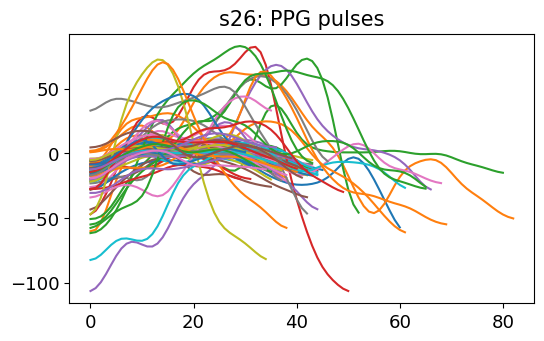

In [162]:
import numpy as np
from scipy.signal import find_peaks
import steps
videoIdx = 54 # 9 good 18,54 bad
winsize = 10
dataset_name = 'ubfc_phys'
dataset = steps.get_dataset(dataset_name)
videoFPS, sigFPS = constants.get_fps(dataset_name)
fname = dataset.getSigFilename(videoIdx)
duration = sigFPS * 60
print(fname)

sigGT = dataset.readSigfile(fname)
PPG = sigGT.data.T.reshape(-1,1,1)[:duration] # shape (n,nb_ldmk,RGB)

interval = [0,4000]
PPG_win, bpmGT, timesGT, fname = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize)
PPG = sigGT.data.T.flatten()[:duration]
peaks, _ = find_peaks(-PPG,distance=30)  # Find the peaks in the inverted signal, so min
plt.figure(figsize=(16,3.5))
plt.plot(PPG)
# plt.plot(peaks, PPG[peaks], "x")
plt.title(f'{fname}: PPG', fontsize=15)

# store all signal between peaks
ppg_pulse = []
for i in range(len(peaks)-1):
    ppg_pulse.append(PPG[peaks[i]:peaks[i+1]])
plt.figure(figsize=(6,3.5))
for pulse in ppg_pulse:
    plt.plot(pulse)
plt.title(f'{fname}: PPG pulses', fontsize=15)
# import plotly.graph_objects as go
# fig = go.Figure()
# for pulse in ppg_pulse:
#     fig.add_trace(go.Scatter(y=pulse))
# fig.show()


Text(0.5, 1.0, 's12: SNR over entire PPG (taking 8s windows)')

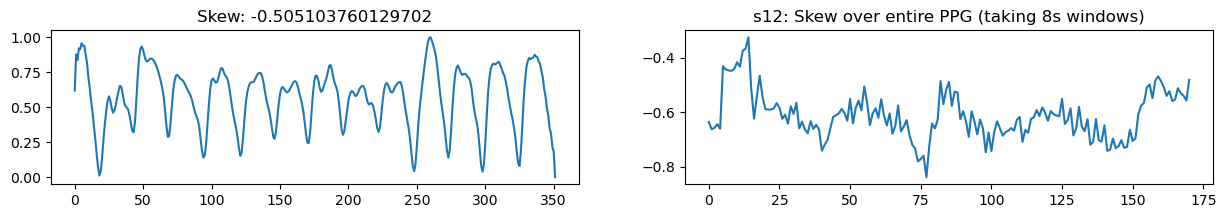

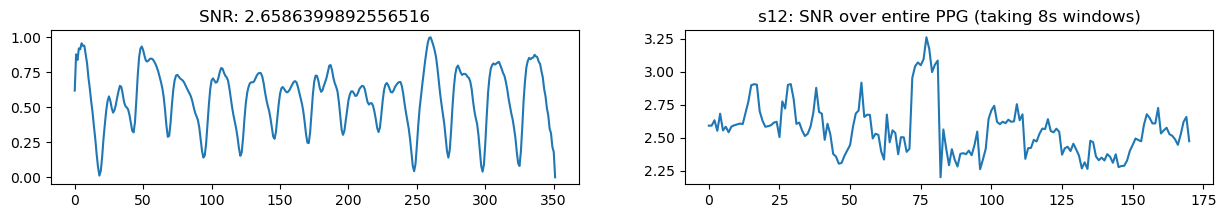

In [35]:
from scipy.stats import skew
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

skewness = skew(PPG_win, axis=1)
snr = signaltonoise(PPG_win, axis=1)
i = 55
fig, ax = plt.subplots(1,2,figsize=(15,2))
ax[0].plot(PPG_win[i])
ax[0].set_title(f'Skew: {skewness[i]}')
ax[1].plot(skewness)
ax[1].set_title(f'{fname}: Skew over entire PPG (taking 8s windows)')

fig, ax = plt.subplots(1,2,figsize=(15,2))
ax[0].plot(PPG_win[i])
ax[0].set_title(f'SNR: {snr[i]}')
ax[1].plot(snr)
ax[1].set_title(f'{fname}: SNR over entire PPG (taking 8s windows)')

In [112]:
df_stat.iloc[0]['skew']

AttributeError: 'list' object has no attribute 'shape'

In [135]:
winsize = 10
dataset_name = 'ubfc_phys'
dataset = steps.get_dataset(dataset_name)
allvideo = dataset.videoFilenames

datas = []
for videoIdx, videoFileName in enumerate(allvideo):
    if 'T1' not in videoFileName:
        continue
    PPG_win, bpmGT, timesGT, fname = steps.get_signal_data(videoIdx, dataset, dataset_name, winsize)
    PPG_win = PPG_win[:60]
    skewness = skew(PPG_win, axis=1)
    snr = signaltonoise(PPG_win, axis=1)
    datas.append([fname, skewness, snr])

    # sigGT = dataset.readSigfile(dataset.getSigFilename(videoIdx))
    # PPG = sigGT.data.T.flatten()[:duration]
    # peaks, _ = find_peaks(-PPG,distance=30)  # Find the peaks in the inverted signal, so min
    # ppg_pulse = []
    # skewness = []
    # snr = []
    # for i in range(len(peaks)-1):
    #     ppg_pulse.append(PPG[peaks[i]:peaks[i+1]])
    #     skewness.append(skew(ppg_pulse[-1]))
    #     snr.append(signaltonoise(ppg_pulse[-1]))
    # datas.append([fname, np.array(skewness), np.array(snr)])

df_stat = pd.DataFrame(datas, columns=['videoFilename','skew', 'snr'])
for column in ['skew', 'snr']:
    df_stat[column+'_mean'] = df_stat[column].apply(lambda x: x.mean())
    df_stat[column+'_std'] = df_stat[column].apply(lambda x: x.std())
    df_stat[column+'_min'] = df_stat[column].apply(lambda x: x.min())
    df_stat[column+'_max'] = df_stat[column].apply(lambda x: x.max())
df_stat = df_stat.drop(columns=['skew', 'snr'])

# Min MAE over all 18 landmarks
df = pd.read_hdf(f'../results/no_overlap/{dataset_name.upper()}/2000_win10-0/{dataset_name.upper()}_18.h5')
df['MAE'] = df['MAE'].apply(lambda x: x[0])
df = df.query('method == "cupy_CHROM"').sort_values(['videoFilename','MAE']).drop_duplicates(['videoFilename']).reset_index(drop=True)

df_stat = df_stat.merge(df[['videoFilename', 'MAE']], on='videoFilename')
df_stat['tmp'] = df_stat['videoFilename'].apply(lambda x: int(x[1:]))
df_stat['video_MAE'] = df_stat.groupby('videoFilename')['MAE'].transform('min')  
df_stat['min(MAE) > 5'] = df_stat['video_MAE'].apply(lambda x: x > 5)
df_stat.head()

,videoFilename,skew_mean,skew_std,skew_min,skew_max,snr_mean,snr_std,snr_min,snr_max,MAE,tmp,video_MAE,min(MAE) > 5
0,s1,-0.460347,0.051186,-0.551476,-0.343680,2.270281,0.202570,1.934276,2.846985,11.445111,1,11.445111,True
1,s10,-0.509950,0.189248,-0.753886,-0.130372,2.554951,0.234401,2.262873,3.259448,0.575356,10,0.575356,False
2,s11,-0.198449,0.572839,-0.808176,1.017749,2.782380,0.612687,2.162433,4.930402,7.530609,11,7.530609,True
3,s12,-0.579058,0.090393,-0.741515,-0.324384,2.622045,0.145590,2.304303,2.917906,0.764098,12,0.764098,False
4,s13,-0.703425,0.286933,-1.468256,-0.389955,2.598654,0.800186,2.060002,4.491469,1.663060,13,1.663060,False


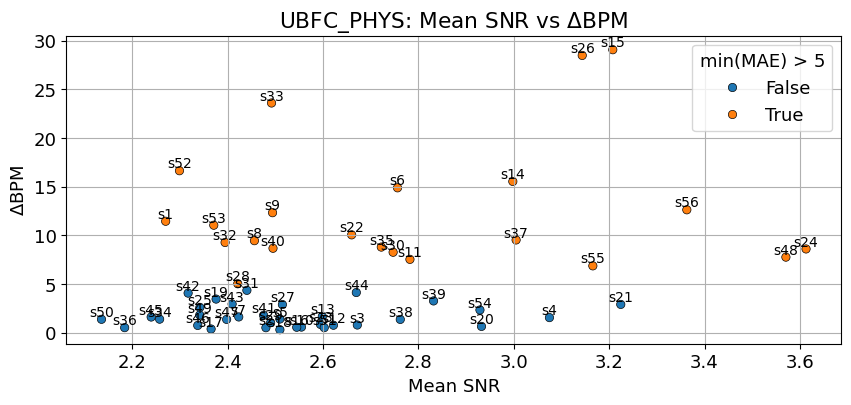

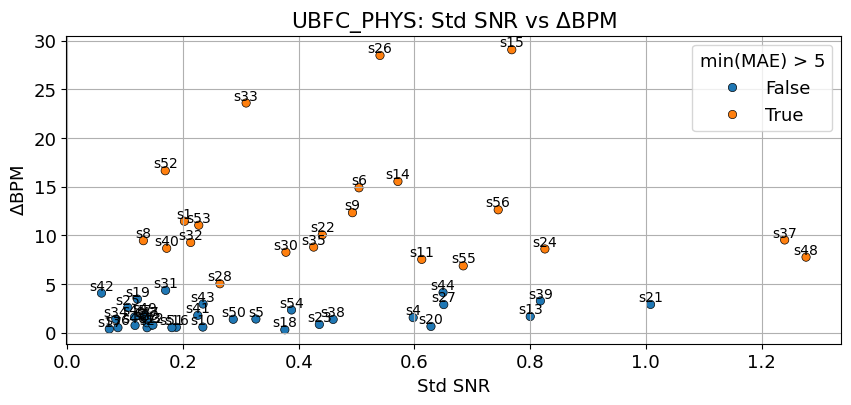

In [143]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})

metric = 'snr'
metric_name = 'SNR'
score = r'$\Delta$' + 'BPM'
plt.figure(figsize=(10, 4))
sns.scatterplot(x=df_stat[f'{metric}_mean'], y=df_stat['MAE'], edgecolors='k', hue=df_stat['min(MAE) > 5'])
for i in range(df_stat.shape[0]):
    plt.text(df_stat[f'{metric}_mean'].iloc[i], df_stat['MAE'].iloc[i], df_stat['videoFilename'].iloc[i], ha='center', va='bottom', fontsize=10)
plt.title(f'{dataset_name.upper()}: Mean {metric_name} vs {score}')
plt.xlabel(f'Mean {metric_name}')
plt.ylabel(score)
plt.grid()
plt.show()

plt.figure(figsize=(10, 4))
sns.scatterplot(x=df_stat[f'{metric}_std'], y=df_stat['MAE'], edgecolors='k', hue=df_stat['min(MAE) > 5'])
for i in range(df_stat.shape[0]): 
    plt.text(df_stat[f'{metric}_std'].iloc[i], df_stat['MAE'].iloc[i], df_stat['videoFilename'].iloc[i], ha='center', va='bottom', fontsize=10)
plt.title(f'{dataset_name.upper()}: Std {metric_name} vs {score}')
plt.xlabel(f'Std {metric_name}')
plt.ylabel(score)
plt.grid()
plt.show()

In [76]:
fig = px.scatter(df_stat, x='skew_mean', y='MAE', text='videoFilename', title=f'{dataset_name.upper()}: Skewness vs MAE')
fig.update_traces(textposition='top center')
fig.show()

fig = px.scatter(df_stat, x='snr_mean', y='MAE', text='videoFilename', title=f'{dataset_name.upper()}: SNR vs MAE')
fig.update_traces(textposition='top center')
fig.show()

fig = px.scatter(df_stat, x='skew_std', y='MAE', text='videoFilename', title=f'{dataset_name.upper()}: Skewness std vs MAE')
fig.update_traces(textposition='top center')
fig.show()

fig = px.scatter(df_stat, x='snr_std', y='MAE', text='videoFilename', title=f'{dataset_name.upper()}: SNR std vs MAE')
fig.update_traces(textposition='top center')
fig.show()